# Previsão de faturamento - Modelo autorregressivo ajustado ao produto `auxilio_final_de_ano`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém o modelo ajustado para o faturamento do produto `auxilio_final_de_ano` mês a mês.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# modelos
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA
#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae, r2_score

# importar scripts
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics

os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [2]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

## Modelo autorregressivo

In [3]:
analise_produto = 'auxilio_final_de_ano'
fat = tswide[analise_produto]
lancamento = tsd[analise_produto].index[0]

antes_lancto = fat[:lancamento].index

fat = fat.drop(index = antes_lancto)

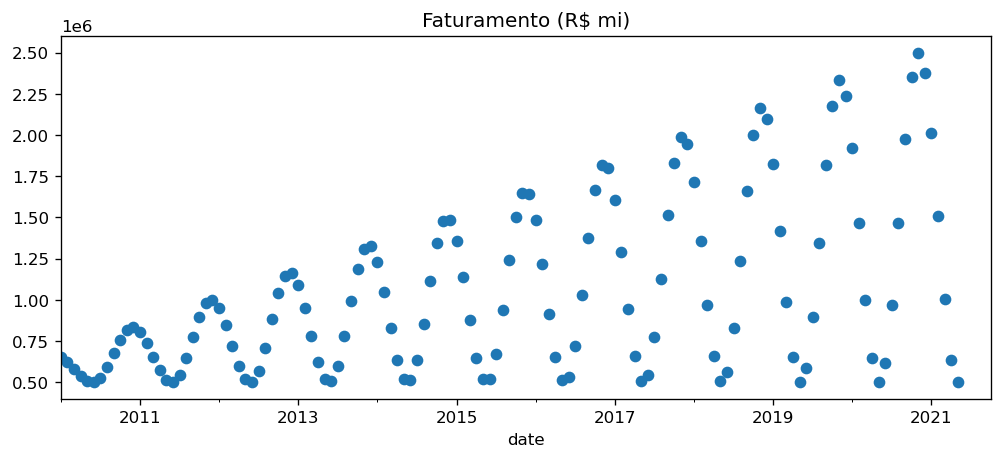

In [4]:
fat.plot(linestyle = '', marker = 'o')
plt.title('Faturamento (R$ mi)')
plt.show()

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

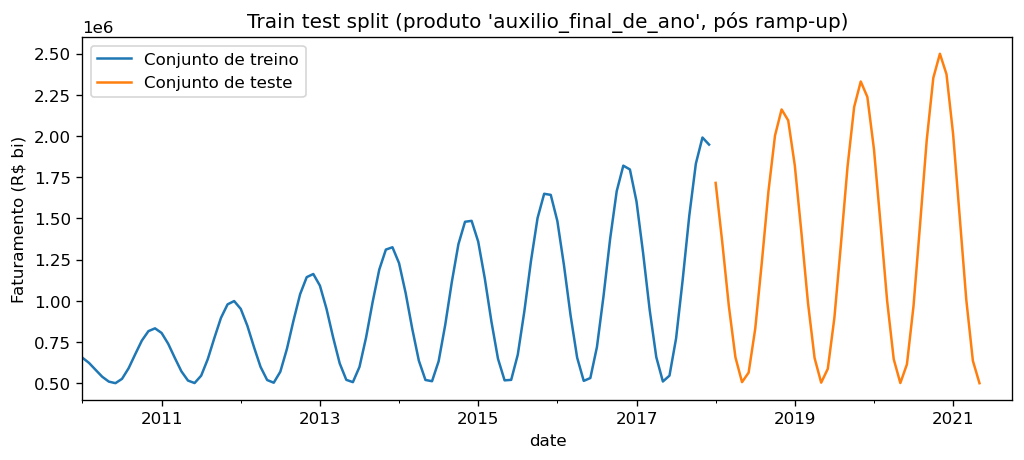

In [5]:
# após ramp-up
fat_modelo = fat.copy()

train_test_split_idx = int(fat_modelo.dropna().shape[0] * 0.7 + 1)
fat_train = fat_modelo[:train_test_split_idx]
fat_test = fat_modelo[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}', pós ramp-up)")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

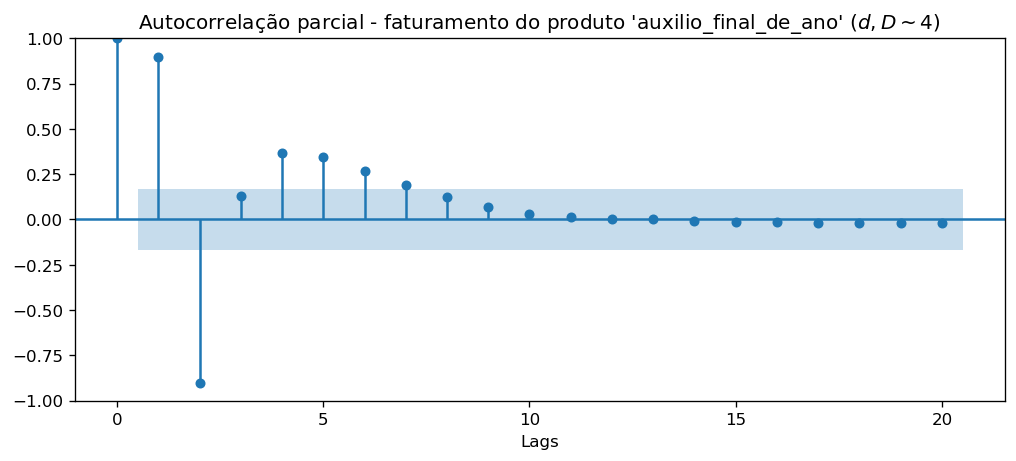

In [6]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_modelo.dropna(), lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - faturamento do produto '{analise_produto}' ($d, D \sim 4$)")
plt.show()

In [7]:
# modelo = auto_arima(
#     y = fat_train,
#     start_p = 1, max_p = 3,
#     d = None, max_d = 5,
#     start_q = 1, max_q = 3,
#     start_P = 1, max_P = 3,
#     D = None, max_D = 5,
#     start_Q = 1, max_Q = 3,
#     #max_order = 6,
#     m = 12,
#     seasonal = True,
#     alpha = 0.05,
#     stepwise = True,
#     trace = True,
#     n_fits = 500,
#     enforce_stationarity = True,
# )

In [8]:
modelo = ARIMA(order = (3, 0, 2), seasonal_order=(1, 6, 0, 12), with_intercept = False).fit(y = fat_train)

C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [9]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   96
Model:             SARIMAX(3, 0, 2)x(1, 6, [], 12)   Log Likelihood                 118.711
Date:                             Sat, 20 Nov 2021   AIC                           -223.423
Time:                                     01:06:00   BIC                           -215.176
Sample:                                          0   HQIC                          -221.235
                                              - 96                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8561      0.004    229.051      0.000       0.849       0.863
ar.L2          0.5056      0.001    443.974      0.000       0.503       0.508
ar.L3         -0.8709   8.58e-07  -1.01e+06      0.000      -0.871      -0.871
ma.L1         -0.1401      0.004    -38.889      0.000      -0.147      -0.133
ma.L2         -0.7826   5.04e-05  -1.55e+04      0.000      -0.783      -0.782
ar.S.L12       0.9993      0.001   1210.912      0.000       0.998       1.001
sigma2      4.233e-09   1.62e-09      2.607      0.009    1.05e-09    7.42e-09
===================================================================================
Ljung-Box (L1) (Q):                  12.27   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.00   Prob(JB):                         0.61
Heteroskedasticity (H):               0.95   Skew:                            -0.20
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+20. Standard errors may be unstable.
"""

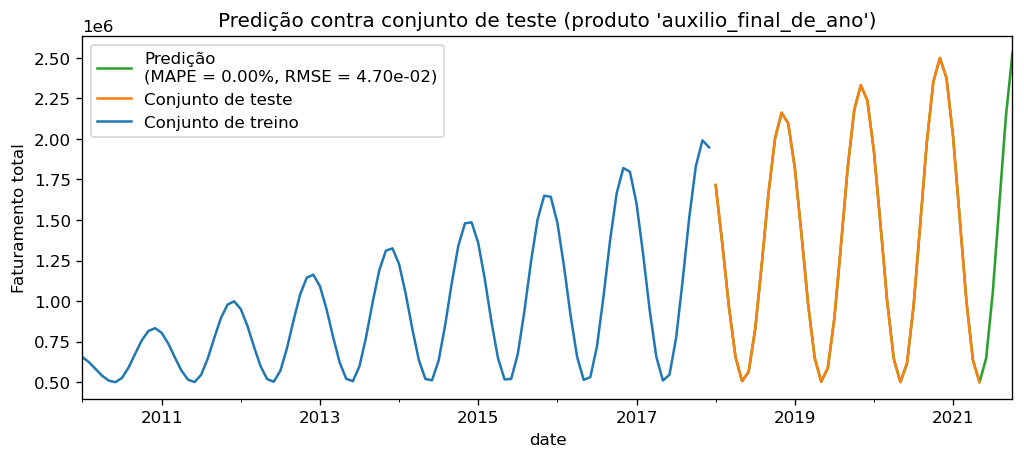

In [10]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test,
    ci = True,
    in_sample = False,
    preds_metrics = True
)

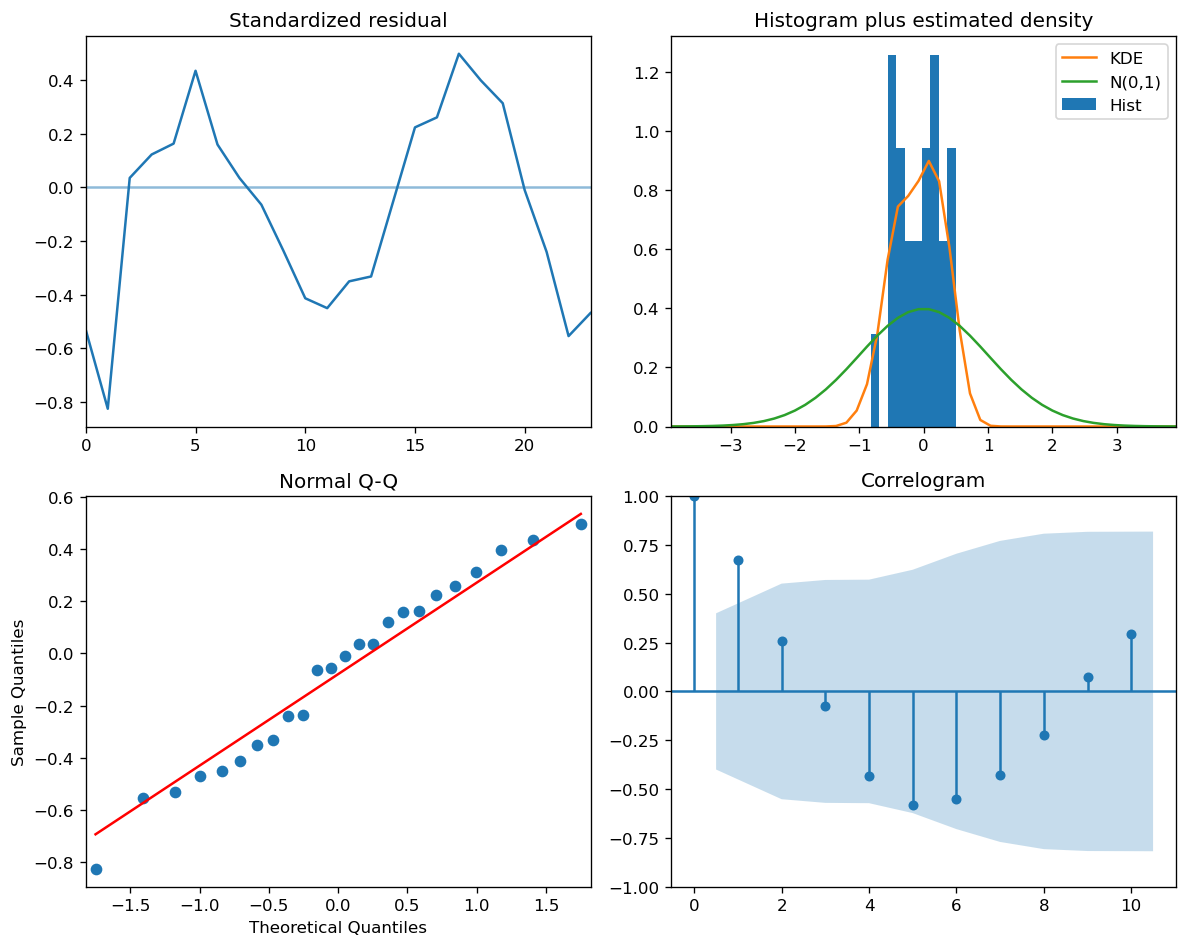

In [11]:
modelo.plot_diagnostics(figsize = (10,8))
plt.tight_layout()
plt.show()

Vamos aplicar algumas métricas ao modelo:

In [12]:
kwargs_ajuste = dict(
    y_true = fat_test.dropna(),
    y_pred = preds[fat_test.dropna().index],
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_ajuste)

Métricas:
       MAPE: 0.000%
       RMSE: 4.697e-02
        MAE: 2.702e-02


Vamos salvar o modelo atual para o faturamento do produto `auxilio_final_de_ano`.

In [13]:
modelo_dict = dict(
    modelo = modelo.fit(fat_train),
    serie_treino = fat_train,
)

with open(r'../models/produto_auxilio.model', 'wb') as arq_modelo_auxilio:
    pickler = pickle.Pickler(file = arq_modelo_auxilio)
    pickler.dump(modelo_dict)


C:\ProgramData\Anaconda3\envs\dsd\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
